# Import modules

In [1]:
import os
import requests                      # HTTP client for API calls
import pandas as pd                  # Tabular data handling
from datetime import datetime        # Datetime handling
from typing import Iterable, Optional, Dict, Union
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf
from pprint import pprint as pp

# Import functions

In [2]:
# Load the autoreload extension
%load_ext autoreload

# Reload all modules automatically before executing a cell
%autoreload 2

from src.debug_print import debug_print
from src.fetch_lse_tickers import get_ftse100
from src.exchange_rates import get_share_prices_2 as share_prices, get_share_prices_2_with_fundamentals
from src.roi_hit import get_first_roi_hit
from src.plot_shares_ROI import plot_candles_volatility_volume_roi as ROI
from src.extract_latest_fundamentals import extract_latest_fundamentals
from src.detect_undervalued import detect_undervalued
from src.utils.email_sender import send_email_html_multi_inline_images, build_roi_email_with_action_images


# Set up variables

In [3]:
base_currency = "GBP"
target_currencies = ["USD", "GBP", "EUR", "JPY"]
cryptos = ["BTC", "ETH"]
shares = ['AAPL', 'RR.L', 'MSFT', 'NVDA', 'LDO.MI','4816.T']

start_date = datetime(2024, 6, 1)
purchase_date = datetime(2025, 8, 1)
end_date = pd.Timestamp.today().normalize()
ROI_target = 0.1
email_sender = "carlo.danieli.trading@gmail.com"
email_sender_psw = "glid qtnr indv wond"


# Get TOP 100 shares from FTSE

In [4]:
ftse100 = get_ftse100()
ftse100["Yahoo_Ticker"] = ftse100["Ticker"] + ".L"
shares_lse = ftse100["Yahoo_Ticker"].to_list()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_ftse100 succeeded


# SHARES PRICES WITH INFO

In [5]:
df_shares_fund = get_share_prices_2_with_fundamentals(
    tickers=shares_lse,
    start=start_date,
    end=end_date,
    base_currency = base_currency,
    vol_window = 20,
    
)

actions_list   = df_shares_fund.columns.get_level_values("ACTION").unique().to_list()
currencies_list = df_shares_fund.columns.get_level_values("CURRENCY").unique()
metrics   = df_shares_fund.columns.get_level_values("METRIC").unique()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_exchange_rates succeeded
[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_share_prices_2_with_fundamentals succeeded


# EXTRACT UNDERVALUED SHARES

In [6]:
df = extract_latest_fundamentals(
    df=df_shares_fund,
    evaluation_date=purchase_date
)
undervalued_shares = detect_undervalued(df)

# UNDERVALUED SHARES' LIST

In [7]:
filt = undervalued_shares[undervalued_shares['UndervaluedScore']>0]
undervalued_shares_list = filt['UndervaluedScore'].index.to_list()

# ANALYZE SHARES' PORTFOLIO to get ROI Dates

In [8]:
portfolio = {}
for action in undervalued_shares_list:
    try:
        action_clean = action.split(".L")[0]
        portfolio[action_clean] = get_first_roi_hit(
        df =  df_shares_fund,
        action=action,
        purchase_date=purchase_date,
        roi_target=ROI_target,
    )
    except Exception as e:
        print(f"{type(e).__name__}: {e}")


In [9]:
# Filter out entries that are None
filtered_portfolio = {k: v for k, v in portfolio.items() if v is not None}
# Sort by 'DATE TO ACHIEVE TARGET'
sorted_data = dict(
    sorted(
        filtered_portfolio.items(),
        key=lambda item: item[1]['DATE TO ACHIEVE TARGET']
    )
)
pp(sorted_data, indent=4)
# Print sorted keys and DATE TO ACHIEVE TARGET
for k, v in sorted_data.items():
    print(k, v['DATE TO ACHIEVE TARGET'])
    # print(k, v)
 

{   'AAL': {   'ACTION': 'AAL.L_GBP→GBP',
               'DATE TARGET MET': Timestamp('2025-08-29 00:00:00+0100', tz='Europe/London'),
               'DATE TO ACHIEVE TARGET': Timedelta('28 days 00:00:00'),
               'EXIT ACTION PRICE': 2278.0,
               'PURCHASE DATE': Timestamp('2025-08-01 00:00:00+0100', tz='Europe/London'),
               'PURCHASE PRICE': 2068.0,
               'SET ROI TARGET': 0.1},
    'GLEN': {   'ACTION': 'GLEN.L_GBP→GBP',
                'DATE TARGET MET': Timestamp('2025-09-25 00:00:00+0100', tz='Europe/London'),
                'DATE TO ACHIEVE TARGET': Timedelta('55 days 00:00:00'),
                'EXIT ACTION PRICE': 332.3500061035156,
                'PURCHASE DATE': Timestamp('2025-08-01 00:00:00+0100', tz='Europe/London'),
                'PURCHASE PRICE': 300.3500061035156,
                'SET ROI TARGET': 0.1},
    'MNG': {   'ACTION': 'MNG.L_GBP→GBP',
               'DATE TARGET MET': Timestamp('2025-12-19 00:00:00+0000', tz='Europe/L

#  PLOT SHARE - plot_candles_volatility_volume_roi 


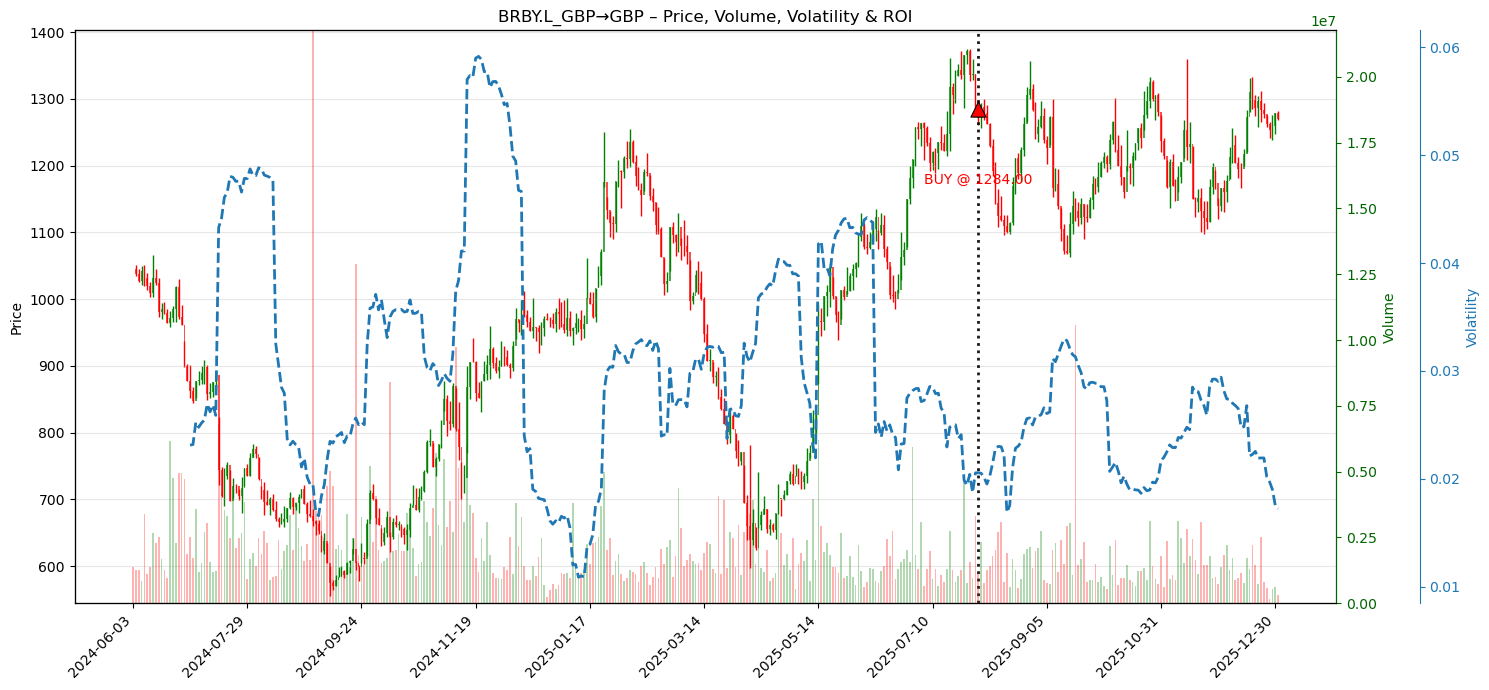

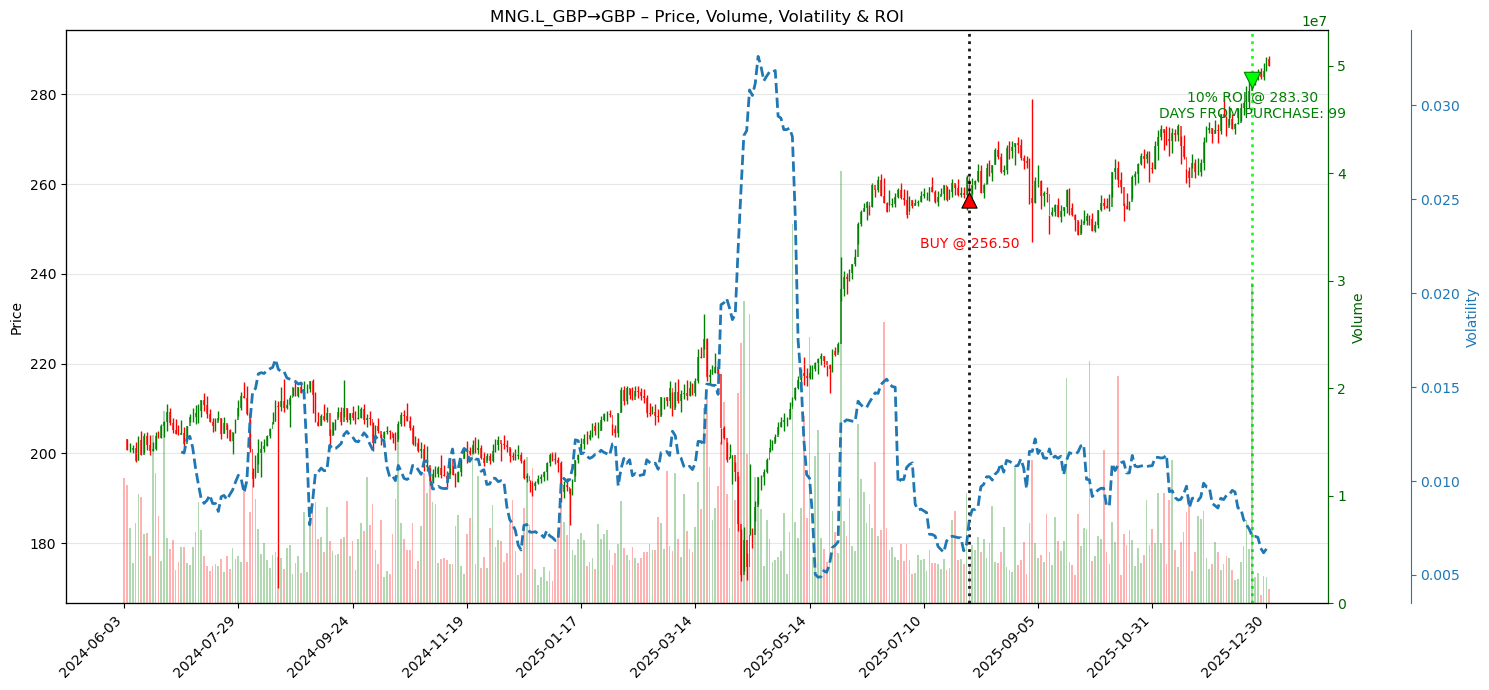

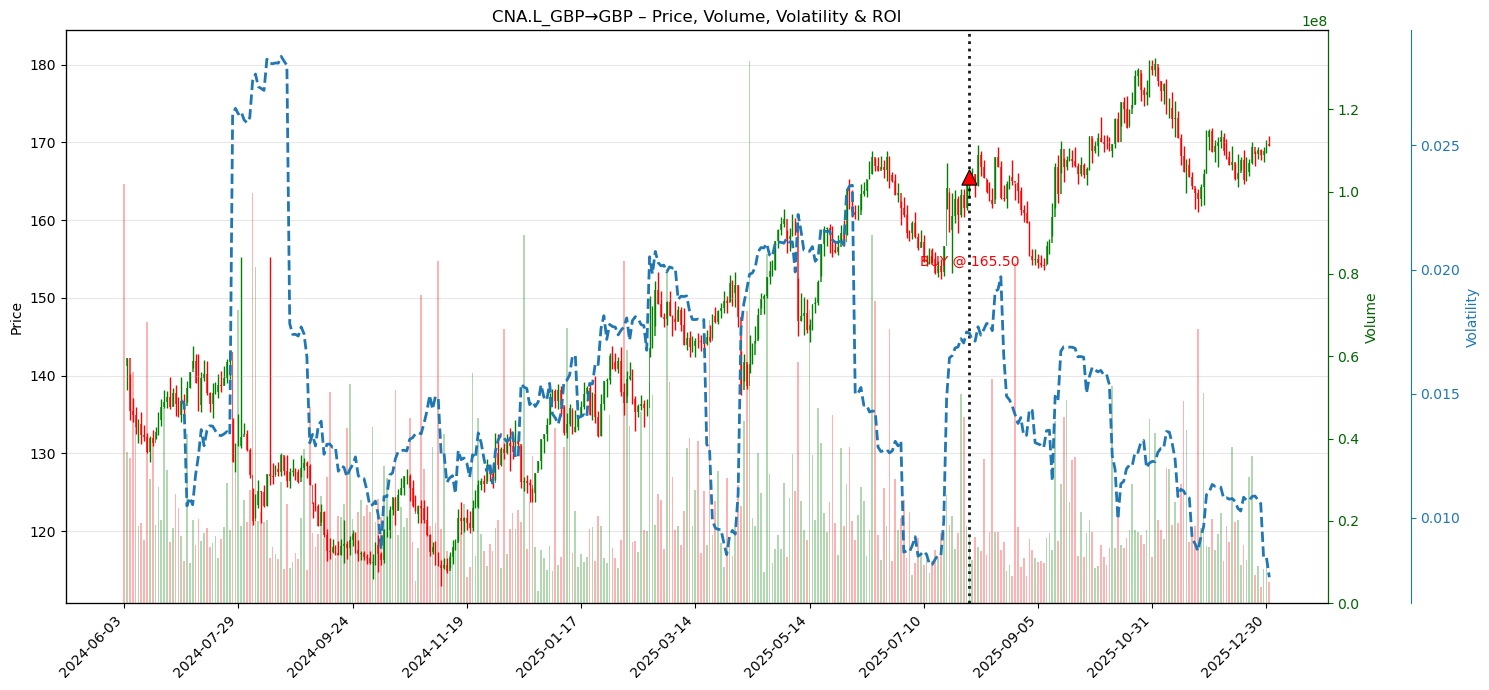

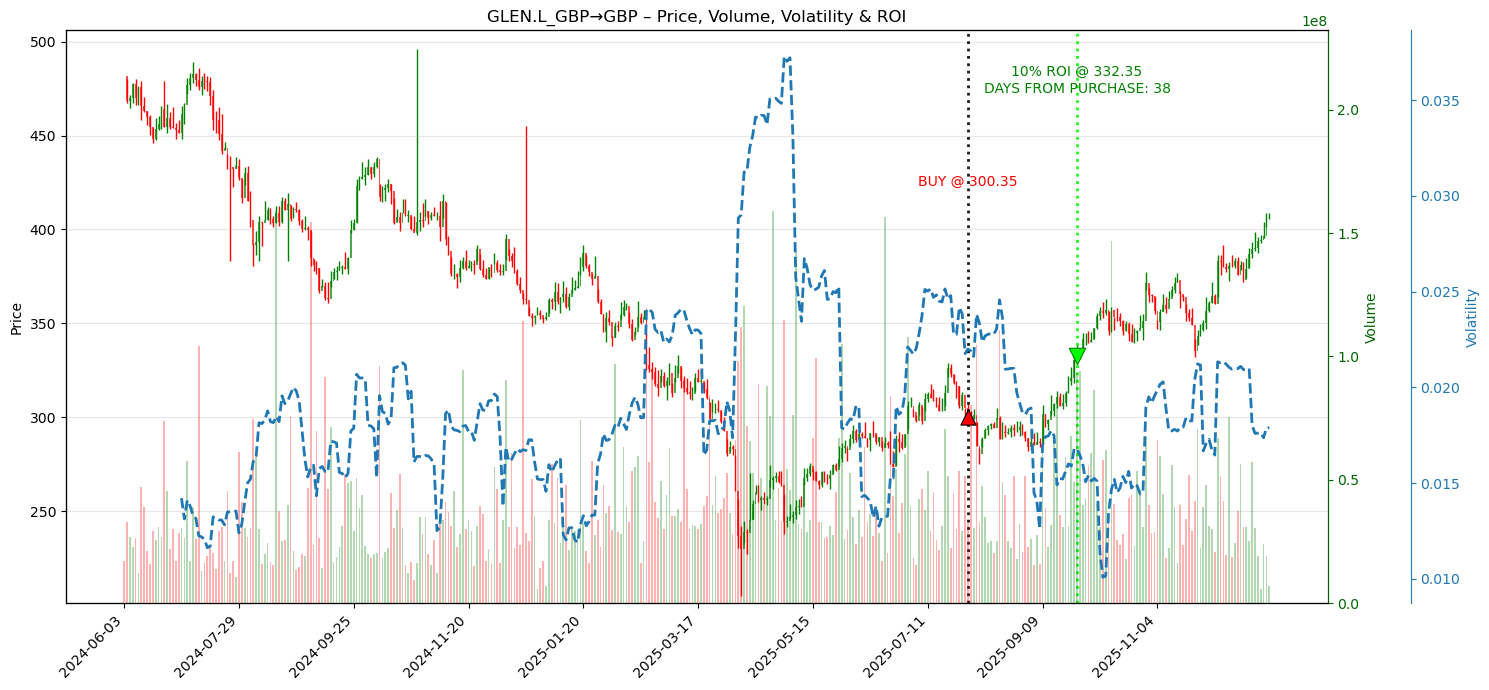

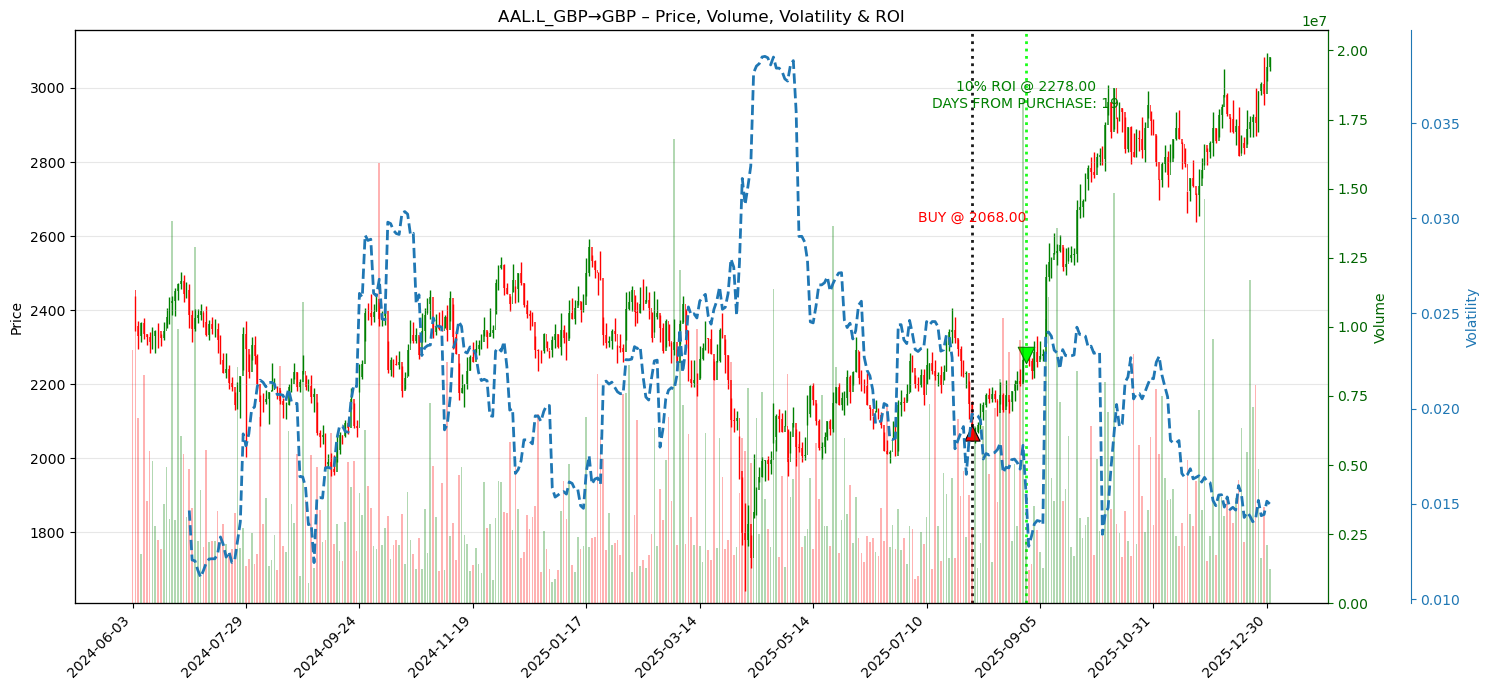

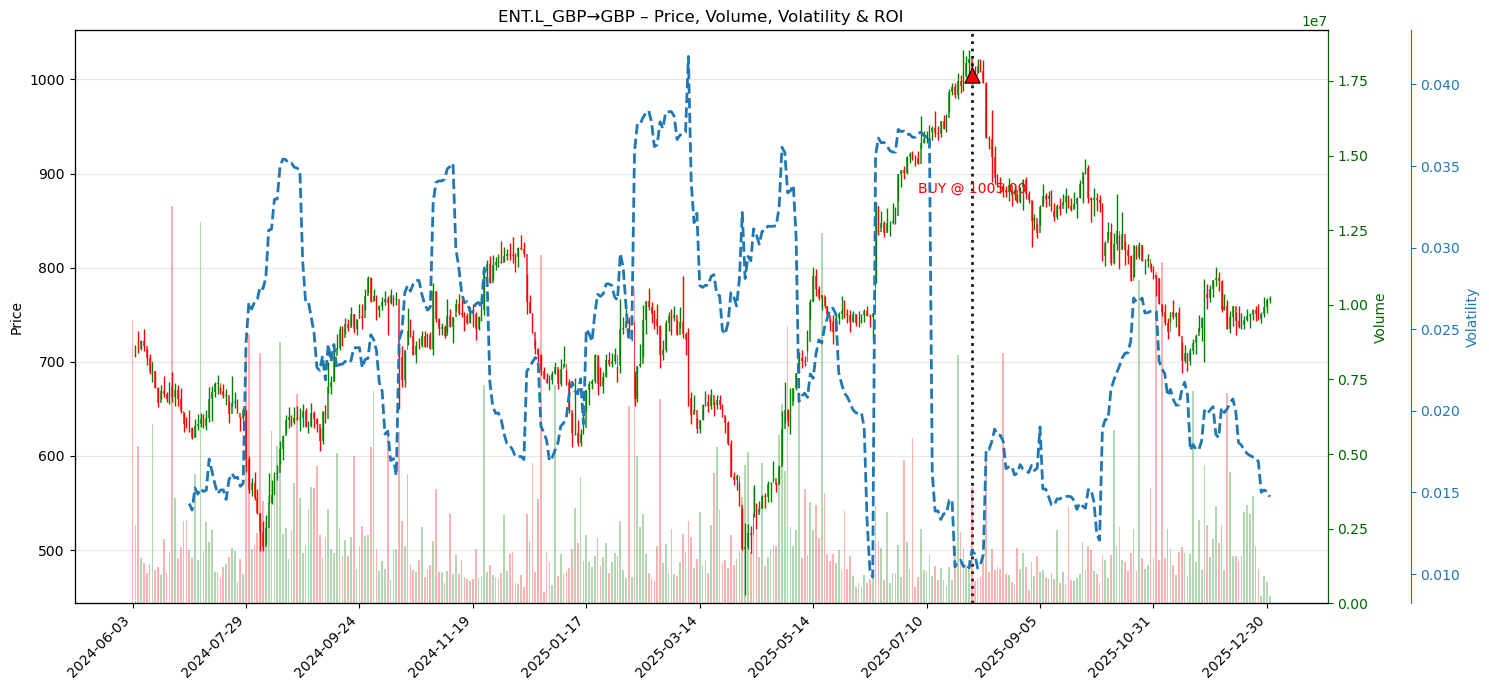

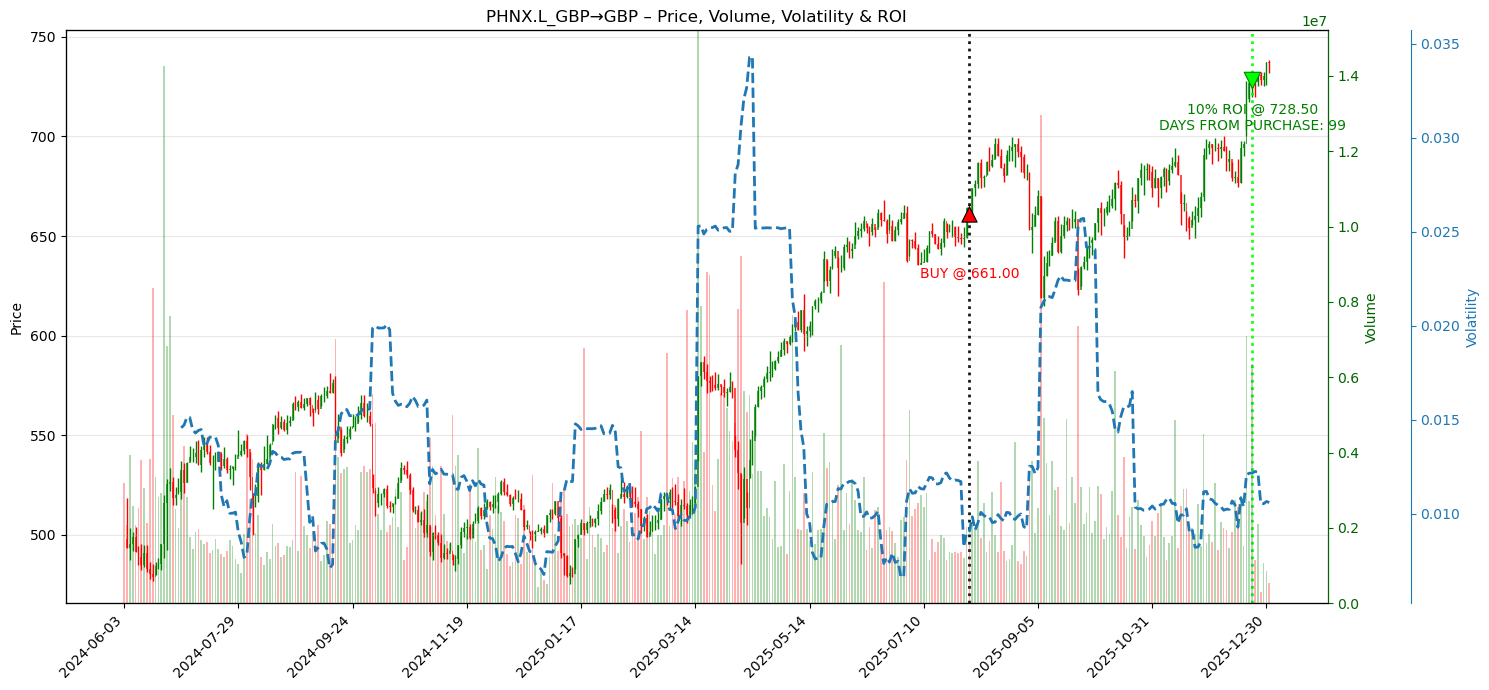

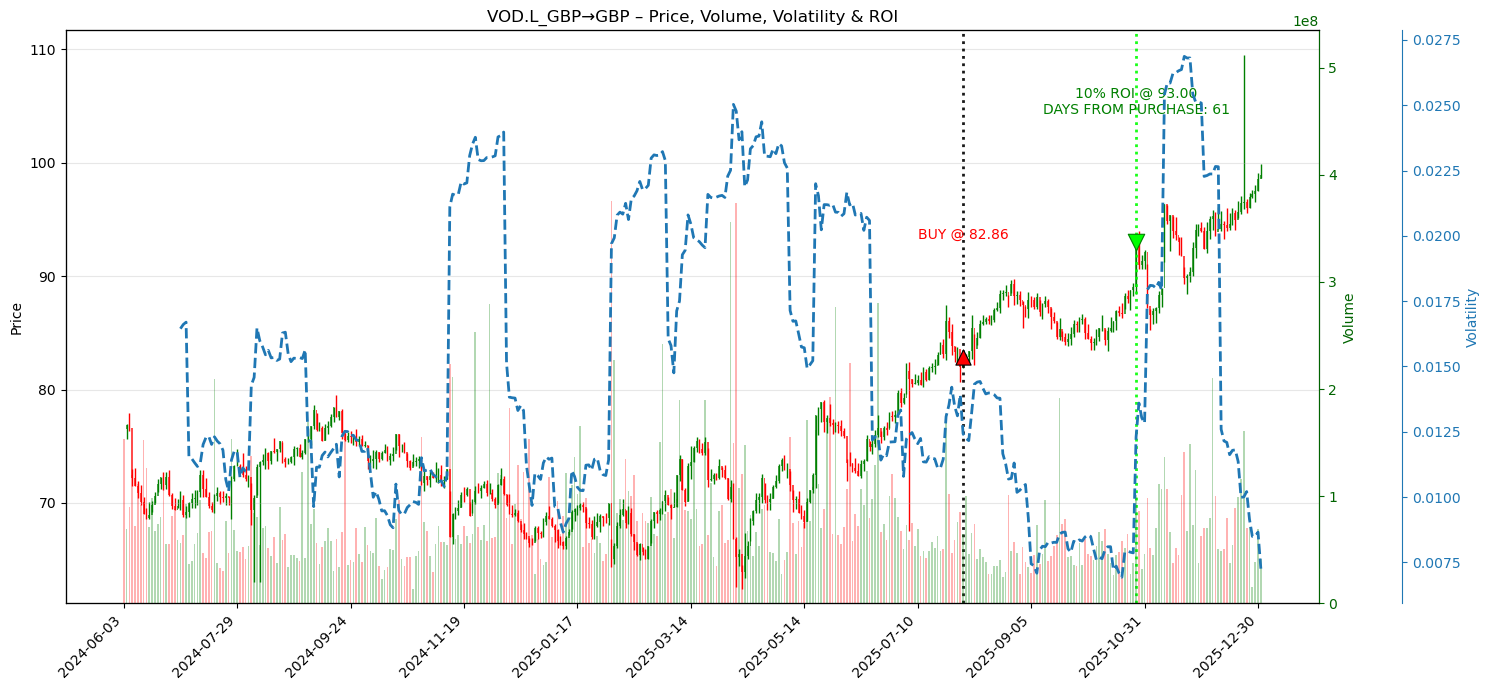

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None plot_candles_volatility_volume_roi succeeded


In [10]:
ROI(
    df=df_shares_fund,
    actions=undervalued_shares_list,
    # actions=actions_list,
    start=df_shares_fund.index.min(),
    end=df_shares_fund.index.max(),
    purchase_date=purchase_date,
    roi_target=ROI_target
)

# EMAIL SENDER

In [11]:
pics_dir = os.path.join(os.getcwd(),"output")
text_body, html_body, inline_images = build_roi_email_with_action_images(
    roi_data=sorted_data,
    image_dir=pics_dir,  # contains AAL.png, VOD.png, ...
)

send_email_html_multi_inline_images(
    smtp_server="smtp.gmail.com",
    smtp_port=587,
    username=email_sender,
    password=email_sender_psw,
    sender=email_sender,
    recipients=["ingcarldan@gmail.com"],
    subject=f"FTSE100 - ROI targets reached – {datetime.today():%d-%m-%Y %H:%M}",
    text_body=text_body,
    html_body=html_body,
    inline_images=inline_images,
)

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None build_roi_email_with_action_images succeeded
[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None send_email_html_multi_inline_images succeeded
